# Accelerated failure time

Setup chunk:

In [1]:
import numpy as np
from scipy.stats import weibull_min # r weibull simulation
from scipy.stats import norm # for covariate simulation
from scipy.stats import gamma # for weibull shape parameter
from scipy.stats import bernoulli # for censoring
from scipy.stats import uniform
from scipy.stats.mstats import mquantiles
import pandas as pd

## Simulated data
Accelerated failure time models take the form
\begin{align}
  \log T = X ^T \beta + \sigma W,
\end{align}
where $T$ is time of failure, $X = (x_1,\dots, x_n) \in \mathbb{R}^{p \times n}$ is the matrix of covariates, $\beta \in \mathbb{R}^p$ is the vector of coefficients,  $\sigma \in \mathbb{R}$ and $W$ is a random variable.

For the linear predictor $X ^T \beta$, let us assume that covariates are independent. If $x_i = (x_{i,1},\dots,x_{i,n}) \in \mathbb{R}^p$, then let $x_{i,j} \sim \mathcal{N}(0,1)$ for $j = 1, \dots p_\text{cont}$ and $x_{i,j} \sim \mathcal{N}(0,1)$ for $j = 1, \dots p_\text{cat}$.

To look at different scalings of variable effects, let $\beta_j \sim \mathcal{N}(0,\tau^2)$, where $\tau$ is to be varied.

## Simulation function

In [13]:
def AFT_sim(tau, n_beta, prop_cat, sigma, W, obs, censor_prop, show_beta = False, pi = 0.5):
    # tau: controls effect sizes
    # n_beta: the number of predictors
    # prop_cat: approximate proportion of the variables that will be categorical, determining p_cont and p_cat
    # W: Random variable to use for W
    # obs: number of observations to simulate
    # censor_prop: proportion of individuals to censored
    # show_beta: prints the linear coefficients used in the simulation (for testing function)
    # pi: probabilities for simulating the probabilities in the Bernoulli disribution for the categorical variables
    
    # simulating beta coefficients
    betas = norm.rvs(size = n_beta)
    # matrix of normal covariates
    X_norm = norm.rvs(size = obs*int(np.floor(n_beta*(1-prop_cat)))).reshape((obs,int(np.floor(n_beta*(1-prop_cat)))))
    # matrix of categorical covariates
    X_cat = bernoulli.rvs(p = pi,size = obs*int(np.ceil(n_beta*(prop_cat)))).reshape((obs,int(np.ceil(n_beta*(prop_cat)))))
    X = np.hstack([X_norm,X_cat])
    
    # calculating linear predictor
    lin_pred = np.matmul(X,betas) 
    
    # creating a dataframe for the simulation
    sim_data = pd.DataFrame(X)
    # simulating survival times AFT model
    sim_data["y"] = np.exp(lin_pred + sigma*W)

    # proportion of censors caused by dropping out
    dropout_prop = uniform.rvs(size = 1, scale = 0.5)
    # quantile above which we censor
    max_time = float(mquantiles(sim_data["y"], prob = (1 - censor_prop)/(1 - dropout_prop*censor_prop)))
    # censoring indicator invdividuals above the quantile
    sim_data["end_censor"] = np.where(sim_data["y"] > max_time,True,False)
    # dropout indicator for individuals not censored by end censoring
    sim_data["dropout"] = np.where(sim_data["end_censor"] == False, bernoulli.rvs(p = dropout_prop*censor_prop, size = len(sim_data)) == 1, False)
    # "end censoring" times
    sim_data["end_censor_time"] = np.where(sim_data["y"] > max_time, max_time, sim_data["y"])
    # simulating the dropout time
    sim_data["time"] = np.where(sim_data["dropout"], uniform.rvs(scale = sim_data["end_censor_time"]), sim_data["end_censor_time"])

    sim_data["event"] = ~(sim_data["dropout"] | sim_data["end_censor"]) 
    
    if show_beta:
        print(betas)
        return(sim_data)
    else:
        return(sim_data)

In [14]:
AFT_sim(1, 10, 0.5, 1, norm.rvs(size = 10), 10, 0.7, show_beta = False, pi = 0.5)

,0,1,2,3,4,5,6,7,8,9,y,end_censor,dropout,end_censor_time,time,event
0,-0.455881,2.241330,-1.400059,0.430077,-0.907481,1.0,0.0,0.0,1.0,0.0,0.020769,False,False,0.020769,0.020769,True
1,1.744884,0.466676,-0.162797,-0.491335,-3.151562,1.0,1.0,1.0,1.0,0.0,0.026621,False,False,0.026621,0.026621,True
2,-1.374308,0.992540,1.093407,3.668213,-0.177939,1.0,0.0,1.0,0.0,0.0,23.083372,True,False,0.111416,0.111416,False
3,1.554997,-0.746270,0.237605,-0.257645,1.399124,1.0,0.0,1.0,1.0,0.0,1.187727,True,False,0.111416,0.111416,False
4,0.111145,0.373478,-0.380837,-1.545885,0.217975,1.0,0.0,0.0,0.0,0.0,0.017950,False,True,0.017950,0.010068,False
5,-0.066585,-1.795677,-1.055495,-0.165112,0.787086,0.0,0.0,0.0,0.0,1.0,63.344164,True,False,0.111416,0.111416,False
6,2.040335,-0.943475,-0.229476,-0.526958,0.715755,0.0,1.0,1.0,0.0,1.0,1.741329,True,False,0.111416,0.111416,False
7,-0.131812,-0.104968,-1.233071,-1.430732,1.029213,1.0,0.0,1.0,0.0,1.0,5.303651,True,False,0.111416,0.111416,False
8,0.126773,-1.296361,-0.328098,0.157524,-0.593675,0.0,0.0,0.0,0.0,1.0,83.057025,True,False,0.111416,0.111416,False
9,-2.089404,0.563438,0.240875,-0.389337,1.820058,1.0,0.0,0.0,1.0,0.0,0.007495,False,True,0.007495,0.002763,False


## Tests
Let us test that the function simulates AFT data from with a log-normal distribution using a plot.

In [21]:
def AFT_sim_test(tau, n_beta, prop_cat, sigma, W, obs, censor_prop, pi = 0.5):
    # tau: controls effect sizes
    # n_beta: the number of predictors
    # prop_cat: approximate proportion of the variables that will be categorical, determining p_cont and p_cat
    # W: Random variable to use for W
    # obs: number of observations to simulate
    # censor_prop: proportion of individuals to censored
    # show_beta: prints the linear coefficients used in the simulation (for testing function)
    # pi: probabilities for simulating the probabilities in the Bernoulli disribution for the categorical variables
    
    # simulating beta coefficients
    betas = norm.rvs(size = n_beta)
    # matrix of normal covariates
    X_norm = norm.rvs(size = obs*int(np.floor(n_beta*(1-prop_cat)))).reshape((obs,int(np.floor(n_beta*(1-prop_cat)))))
    # matrix of categorical covariates
    X_cat = bernoulli.rvs(p = pi,size = obs*int(np.ceil(n_beta*(prop_cat)))).reshape((obs,int(np.ceil(n_beta*(prop_cat)))))
    X = np.hstack([X_norm,X_cat])
    
    # calculating linear predictor
    lin_pred = np.matmul(X,betas) 
    
    # creating a dataframe for the simulation
    sim_data = pd.DataFrame(X)
    # simulating survival times AFT model
    sim_data["y"] = np.exp(lin_pred + sigma*W)

    # proportion of censors caused by dropping out
    dropout_prop = uniform.rvs(size = 1, scale = 0.5)
    # quantile above which we censor
    max_time = float(mquantiles(sim_data["y"], prob = (1 - censor_prop)/(1 - dropout_prop*censor_prop)))
    # censoring indicator invdividuals above the quantile
    sim_data["end_censor"] = np.where(sim_data["y"] > max_time,True,False)
    # dropout indicator for individuals not censored by end censoring
    sim_data["dropout"] = np.where(sim_data["end_censor"] == False, bernoulli.rvs(p = dropout_prop*censor_prop, size = len(sim_data)) == 1, False)
    # "end censoring" times
    sim_data["end_censor_time"] = np.where(sim_data["y"] > max_time, max_time, sim_data["y"])
    # simulating the dropout time
    sim_data["time"] = np.where(sim_data["dropout"], uniform.rvs(scale = sim_data["end_censor_time"]), sim_data["end_censor_time"])

    sim_data["event"] = ~(sim_data["dropout"] | sim_data["end_censor"]) 
    
    return(sim_data,betas)

In [22]:
import matplotlib.pyplot as plt

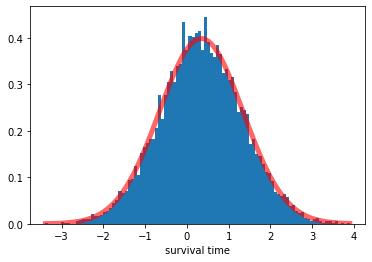

In [28]:
sample, betas = AFT_sim_test(1, 1, 1, 1, norm.rvs(size = 10000), 10000, 0, pi = 1)

x = np.linspace(min(np.log(sample["time"])),max(np.log(sample["time"])),100)

fig,ax = plt.subplots(1,1)
a = np.log(sample["time"])
ax.hist(a,bins = 100, density = True)
ax.plot(x, norm.pdf(x, loc = betas),
       'r-', lw=5, alpha=0.6, label='normal pdf')
ax.set_xlabel('survival time')
plt.show()

Untransformed distribution:

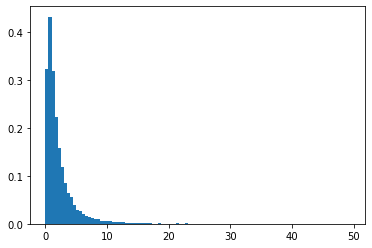

In [30]:
fig,ax = plt.subplots(1,1)
a = sample["time"]
ax.hist(a,bins = 100, density = True)
plt.show()